Notebook to run logistic regression on small (conductor up to 5000) dataset, and check its accuracy compared to the full dataset.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler



## 0. Run the logistic regression model on the small dataset.

In [2]:
# Load the dataframe
df = pd.read_csv("../data_files/ecq_rank_0_or_1_cond_limit_5000_one_per_isog_class_balanced.csv")
# Print the first few rows of the dataframe
print(df.head())

   2  3  5  7  11  13  17  19  23  29  ...  1163  1171  1181  1187  1193  \
0  0  0  3  4   0   3   3   4  -8  -5  ...   -52    20    11   -24   -29   
1  2 -3  1  4  -1   6   4  -2   3   1  ...   -42    35    30   -12    -9   
2  0  0 -2  0  -4  -2   6  -8   0   6  ...     4   -20   -18   -36     6   
3 -1  0  1  4   1   2  -2   4   4  -6  ...    36    12   -34   -12     6   
4 -1  1  0 -3   2   1  -3  -1   1  -5  ...   -44    -8    57    32   -24   

   1201  1213  1217  1223  rank  
0    15    14   -33    56     0  
1   -40    -9     8    36     0  
2     2     6    -2    24     1  
3   -30   -26    -2    40     0  
4    17    36    37    -9     1  

[5 rows x 201 columns]


In [3]:
# But the columns themselves are strings!
column_names = df.columns.tolist()
column_types = set([type(name) for name in column_names])
print("The column names are of type: ", column_types)

# Divide dataframe into features and label (rank); change data types to float
X = df.drop(columns=['rank']).values.astype(np.float32)
y = df['rank'].values.astype(np.float32)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

print("The training set has ", X_train.shape[0], " examples.")
print("The test set has ", X_test.shape[0], " examples.")


The column names are of type:  {<class 'str'>}
The training set has  1348  examples.
The test set has  900  examples.


In [4]:
# Scale the features
primes_strings = column_names[:-1]
primes = [int(primes_strings[i]) for i in range(len(primes_strings))]
def scale_by_ap(data_set):
    scaling_factor = [1/(2*np.sqrt(primes[i])) for i in range(len(primes))]
    scaling_factor = np.array(scaling_factor, dtype=np.float32)
    return data_set * scaling_factor

# scaler = StandardScaler()
X_train = scale_by_ap(X_train)
X_test = scale_by_ap(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train).view(-1, 1)  # Reshape y to be a column vector
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test).view(-1, 1)  # Reshape y to be a column vector


In [5]:
del df, X, y, X_train, y_train, X_test, y_test

In [7]:
# Create DataLoader for training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# Define the logistic regression model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

input_dim = X_train_tensor.shape[1]
model = LogisticRegressionModel(input_dim)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

print("Now we train")
# Train the model
num_epochs = 40

for epoch in range(num_epochs):
    for inputs, labels in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model on the test set
with torch.no_grad():
    predicted = model(X_test_tensor).round()
    accuracy = (predicted.eq(y_test_tensor).sum().item()) / y_test_tensor.size(0)
    print(f'Accuracy on test set: {accuracy * 100:.2f}%')


Now we train
Epoch [10/40], Loss: 0.0212
Epoch [20/40], Loss: 0.0455
Epoch [30/40], Loss: 0.0104
Epoch [40/40], Loss: 0.0601
Accuracy on test set: 99.33%


## 1. Calculate the accuracy of the model on the large dataset for each interval (2^n, 2^(n+1)]

In [8]:
df_big = pd.read_csv('../data_files/ecq_B_200_all_one_per_iso.csv')
df_big.head()

,2,3,5,7,11,13,17,19,23,29,...,1171,1181,1187,1193,1201,1213,1217,1223,conductor,rank
0,-0.7071,-0.2887,0.2236,-0.3780,0.1508,0.5547,-0.2425,0.0000,-0.1043,0.0000,...,-0.0438,-0.2619,-0.1742,-0.3040,0.0289,-0.5886,-0.602,0.2002,11,0
1,-0.3536,-0.5774,0.0000,0.1890,0.0000,-0.5547,0.7276,0.2294,0.0000,-0.5571,...,0.2922,0.8730,-0.1742,0.9554,0.2020,0.3733,-0.086,-0.3431,14,0
2,-0.3536,-0.2887,0.2236,0.0000,-0.6030,-0.2774,0.2425,0.4588,0.0000,-0.1857,...,-0.1753,-0.4947,0.1742,-0.5501,-0.2020,-0.2584,0.258,0.2288,15,0
3,-0.3536,0.0000,-0.4472,0.7559,0.0000,-0.2774,0.1213,-0.4588,0.4170,0.5571,...,0.4091,-0.4947,0.0000,0.3764,-0.2020,-0.1436,0.946,-0.8007,17,0
4,0.0000,-0.5774,0.6708,-0.1890,0.4523,-0.5547,-0.3638,0.1147,0.0000,0.5571,...,0.8182,-0.2619,0.6966,0.5211,0.0721,-0.6604,0.430,0.6434,19,0


In [10]:
# take the rows with 0 or 1 rank
df = df_big[df_big['rank'].isin([0, 1])]
del df_big
print(df.shape)

(1876304, 202)


In [14]:
# Divide up dataframes
dfs = {n: df[(df['conductor']> 2**n) & (df['conductor'] <= 2**(n+1))] for n in range(3, 19)}
for item in dfs:
    print(f"Dataframe {item} has shape {dfs[item].shape}")
del df

Dataframe 3 has shape (3, 202)
Dataframe 4 has shape (10, 202)
Dataframe 5 has shape (36, 202)
Dataframe 6 has shape (92, 202)
Dataframe 7 has shape (253, 202)
Dataframe 8 has shape (603, 202)
Dataframe 9 has shape (1528, 202)
Dataframe 10 has shape (3374, 202)
Dataframe 11 has shape (7428, 202)
Dataframe 12 has shape (15796, 202)
Dataframe 13 has shape (32177, 202)
Dataframe 14 has shape (65516, 202)
Dataframe 15 has shape (129148, 202)
Dataframe 16 has shape (255442, 202)
Dataframe 17 has shape (496366, 202)
Dataframe 18 has shape (868532, 202)


In [25]:
# Calculate the accuracy
accs = {}
for n in dfs:
    X_verify = dfs[n].drop(columns=['rank', 'conductor']).values.astype(np.float32)
    y_verify = dfs[n]['rank'].values.astype(np.float32)
    X_verify_tensor = torch.tensor(X_verify)
    y_verify_tensor = torch.tensor(y_verify).view(-1, 1)  # Reshape y to be a column vector

    # Evaluate the model on the test set
    with torch.no_grad():
    
        predicted = model(X_verify_tensor).round()
        accuracy = (predicted.eq(y_verify_tensor).sum().item()) / y_verify_tensor.size(0)
        print(f'Accuracy on test set for key {n} is: {accuracy * 100:.2f}%')
        accs[n]=accuracy


Accuracy on test set for key 3 is: 100.00%
Accuracy on test set for key 4 is: 90.00%
Accuracy on test set for key 5 is: 97.22%
Accuracy on test set for key 6 is: 97.83%
Accuracy on test set for key 7 is: 99.21%
Accuracy on test set for key 8 is: 100.00%
Accuracy on test set for key 9 is: 99.74%
Accuracy on test set for key 10 is: 96.86%
Accuracy on test set for key 11 is: 93.13%
Accuracy on test set for key 12 is: 88.12%
Accuracy on test set for key 13 is: 82.78%
Accuracy on test set for key 14 is: 72.10%
Accuracy on test set for key 15 is: 60.78%
Accuracy on test set for key 16 is: 52.38%
Accuracy on test set for key 17 is: 47.20%
Accuracy on test set for key 18 is: 45.83%


## 2. Plot the accuracy

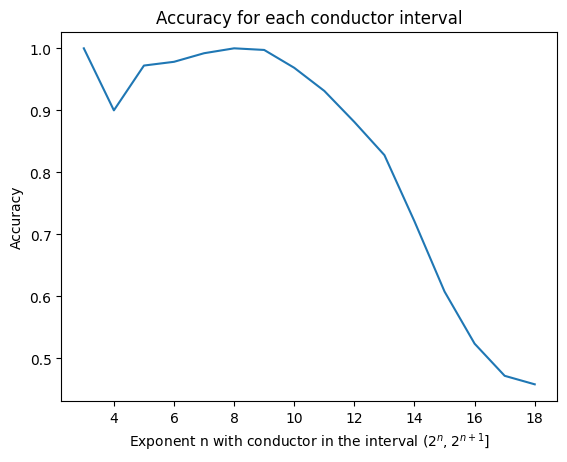

In [24]:
import matplotlib.pyplot as plt


# Create a line plot
plt.plot(list(accs.keys()), list(accs.values()))

# Optionally, add a title and labels
plt.title('Accuracy for each conductor interval')
plt.xlabel('Exponent n with conductor in the interval $(2^n, 2^{n+1}]$')
plt.ylabel('Accuracy')

# Show the plot
plt.show()